In [1]:
%matplotlib inline

import os
import glob
from pathlib import Path
import ssl
import random
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_model_optimization as tfmot
import tensorflow_datasets as tfds
from tensorflow.python.client import device_lib


# if using remote server
current_path = os.path.basename(os.path.normpath(os.getcwd()))
DIR = "digit-classifier"
if(current_path != DIR):
	os.chdir(DIR)
	print("Changed directory into: "+DIR)

SEED = 2
BATCH_SIZE = 128

#tf.random.set_seed(SEED)

# Disable all GPUs
#tf.config.set_visible_devices([], 'GPU') # must restart kernal to re-enable GPUs

print(tf.config.get_visible_devices())

# gpu optimizations
tf.config.optimizer.set_jit(True)


# shortcuts
layers = tf.keras.layers

C:\Users\alex\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Changed directory into: digit-classifier
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
# Construct a tf.data.Dataset
(train_dataset, val_dataset), metadata = tfds.load('mnist', split=['train', 'test[:20%]'], as_supervised=True, with_info=True)

def normalize_img(image, label):
	"""Normalizes images: `uint8` -> `float32`."""
	return tf.cast(image, tf.float32) / 255., label

ds_img_shape = metadata.features['image'].shape
num_classes = metadata.features['label'].num_classes
train_num_examples = metadata.splits['train'].num_examples
val_num_examples = metadata.splits['test'].num_examples

get_label_name = metadata.features['label'].int2str

#print(metadata)

In [4]:
image_augmentations = tf.keras.Sequential([
	layers.RandomRotation(0.1),
	layers.RandomContrast(0.1),
	layers.RandomZoom(0.1),
	layers.RandomTranslation(0.1, 0.1),
	layers.GaussianNoise(0.1)
])

def augment_images(ds):
	return ds.map(lambda x,y: (image_augmentations(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

In [5]:
def prepare(ds, shuffle=False, batch=True, augment=False, cache=True, prefetch=True):
	if(augment):
		ds = ds.map(lambda x,y: (image_augmentations(x), y), num_parallel_calls=tf.data.AUTOTUNE)
	if(cache):
		ds = ds.cache() # cache
	if shuffle:
		ds = ds.shuffle(shuffle) # shuffle
	if batch:
		ds = ds.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
	if prefetch:
		ds = ds.prefetch(tf.data.AUTOTUNE)
	return ds

In [6]:
train_dataset = train_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = prepare(train_dataset, shuffle=train_num_examples, augment=True)
val_ds = prepare(val_dataset, shuffle=val_num_examples, augment=False)

In [7]:
#create model
def create_model(input_shape=(28,28,1)):
	model = tf.keras.Sequential()

	model.add(layers.Input(shape=input_shape))
	#model.add(layers.BatchNormalization())

	# base_model = tf.keras.applications.VGG16(
	# 	include_top=False,
	# 	weights='imagenet'
	# )
	# base_model.trainable = False
	# model.add(base_model)

	model.add(layers.Conv2D(filters=128, kernel_size=5, activation="relu", padding="same"))
	model.add(layers.MaxPool2D(pool_size=2))
	model.add(layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"))
	model.add(layers.MaxPool2D(pool_size=2))
	model.add(layers.Dropout(0.5))

	model.add(layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"))
	model.add(layers.MaxPool2D(pool_size=2))
	model.add(layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding="same"))
	model.add(layers.MaxPool2D(pool_size=2))
	model.add(layers.Dropout(0.5))


	model.add(layers.Flatten())

	model.add(layers.Dense(units=1024, activation="relu"))
	model.add(layers.Dense(units=512, activation="relu"))
	
	model.add(layers.Dropout(0.5))
	model.add(layers.Dense(num_classes, activation='softmax'))
		
	return model

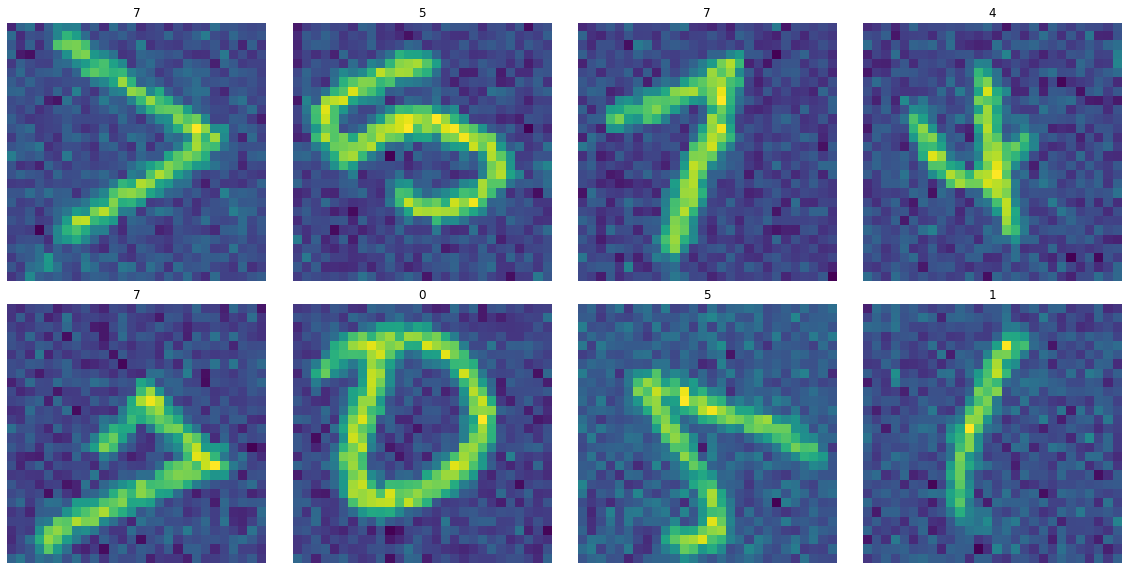

In [8]:
#plot images
fig, axes = plt.subplots(2,4, figsize=(16, 8))
val_ds_examples = val_ds.unbatch().take(8)
val_ds_examples = augment_images(val_ds_examples)

for idx, elem in enumerate(val_ds_examples):
	ax = axes.flat[idx]
	image = elem[0].numpy()
	label = elem[1].numpy()
	ax.imshow(image)
	ax.set_title(label)
	ax.axis("off")
plt.tight_layout()
plt.show()

In [70]:
model = create_model()
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

with tf.device("/GPU:0"):
	model.compile(
		optimizer='adam',
		loss='sparse_categorical_crossentropy',
		metrics=['sparse_categorical_accuracy'],
	)

log_dir = "logs/fit/"
log_time = datetime.datetime.now().strftime("%Y%m%d-%H%M")
log_file = log_dir + log_time
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_file, histogram_freq=1)

In [10]:
%tensorboard --logdir logs/fit/ --bind_all

Reusing TensorBoard on port 6006 (pid 33440), started 1 day, 9:03:41 ago. (Use '!kill 33440' to kill it.)

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)        

In [12]:
callbacks = [
	tensorboard_callback,
	tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss', restore_best_weights=True),
	tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-7, patience=3, mode='min', verbose=1, factor=0.1),
]

with tf.device("/GPU:0"):
	history = model.fit(
		train_ds,
		epochs=15,
		validation_data=val_ds,
		callbacks=callbacks
	)

Epoch 1/15
469/469 [==============================] - 16s 15ms/step - loss: 0.3259 - sparse_categorical_accuracy: 0.8911 - val_loss: 0.0309 - val_sparse_categorical_accuracy: 0.9905 - lr: 0.0010
Epoch 2/15
469/469 [==============================] - 9s 20ms/step - loss: 0.0767 - sparse_categorical_accuracy: 0.9794 - val_loss: 0.0391 - val_sparse_categorical_accuracy: 0.9880 - lr: 0.0010
Epoch 3/15
469/469 [==============================] - 6s 13ms/step - loss: 0.0567 - sparse_categorical_accuracy: 0.9845 - val_loss: 0.0268 - val_sparse_categorical_accuracy: 0.9915 - lr: 0.0010
Epoch 4/15
469/469 [==============================] - 6s 13ms/step - loss: 0.0494 - sparse_categorical_accuracy: 0.9867 - val_loss: 0.0160 - val_sparse_categorical_accuracy: 0.9955 - lr: 0.0010
Epoch 5/15
469/469 [==============================] - 6s 13ms/step - loss: 0.0438 - sparse_categorical_accuracy: 0.9880 - val_loss: 0.0233 - val_sparse_categorical_accuracy: 0.9935 - lr: 0.0010
Epoch 6/15
469/469 [=========

In [72]:
PRUNE = True
if(PRUNE):
	# Pruning
	score = model.evaluate(val_ds, verbose=0)
	print(f'Regular CNN - Test loss: {score[0]} / Test accuracy: {score[1]}')

	# Load functionality for adding pruning wrappers
	prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

	# Finish pruning after 5 epochs
	pruning_epochs = 5
	num_images = train_num_examples
	end_step = np.ceil(num_images / BATCH_SIZE).astype(np.int32) * pruning_epochs

	# Define pruning configuration
	pruning_params = {
		'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.40,
																final_sparsity=0.70,
																begin_step=0,
																end_step=end_step)
	}
	model_fast = prune_low_magnitude(model, **pruning_params)

	# Recompile the model
	model_fast.compile(loss="sparse_categorical_crossentropy",
				optimizer="adam",
				metrics=['sparse_categorical_accuracy'])

	# Model callbacks
	callbacks = [
		tfmot.sparsity.keras.UpdatePruningStep()
	]

	# Fitting data
	with tf.device('/gpu:0'):
		model_fast.fit(train_ds,
							batch_size=BATCH_SIZE,
							epochs=pruning_epochs,
							callbacks=callbacks,
							validation_data=val_ds,
							)

	# Generate generalization metrics
	score_pruned = model_fast.evaluate(val_ds, verbose=0)
	print(f'Pruned CNN - Test loss: {score_pruned[0]} / Test accuracy: {score_pruned[1]}')
	print(f'Regular CNN - Test loss: {score[0]} / Test accuracy: {score[1]}')

Regular CNN - Test loss: 2.3025996685028076 / Test accuracy: 0.10850000381469727
Epoch 1/5
469/469 [==============================] - 13s 20ms/step - loss: 0.3097 - sparse_categorical_accuracy: 0.8964 - val_loss: 0.0455 - val_sparse_categorical_accuracy: 0.9855
Epoch 2/5
469/469 [==============================] - 9s 19ms/step - loss: 0.0675 - sparse_categorical_accuracy: 0.9811 - val_loss: 0.0363 - val_sparse_categorical_accuracy: 0.9880
Epoch 3/5
469/469 [==============================] - 8s 17ms/step - loss: 0.0520 - sparse_categorical_accuracy: 0.9856 - val_loss: 0.0275 - val_sparse_categorical_accuracy: 0.9910
Epoch 4/5
469/469 [==============================] - 8s 17ms/step - loss: 0.0425 - sparse_categorical_accuracy: 0.9880 - val_loss: 0.0222 - val_sparse_categorical_accuracy: 0.9925
Epoch 5/5
469/469 [==============================] - 8s 17ms/step - loss: 0.0331 - sparse_categorical_accuracy: 0.9905 - val_loss: 0.0256 - val_sparse_categorical_accuracy: 0.9905
Pruned CNN - Test 

In [71]:

best_accuracy = round(max(history.history['val_sparse_categorical_accuracy'])*100, 4)

if PRUNE:
	save_name = "digit_classifier_pruned"
	final_name = "{}_{}_{}".format(save_name, best_accuracy, log_time)
	model_fast.save(final_name+'.h5')
else:
	save_name = "digit_classifier"
	final_name = "{}_{}_{}".format(save_name, best_accuracy, log_time)
	model.save(final_name+'.h5')

16/16 [==============================] - 0s 22ms/step
7 wrong predictions found out of 2000 correct


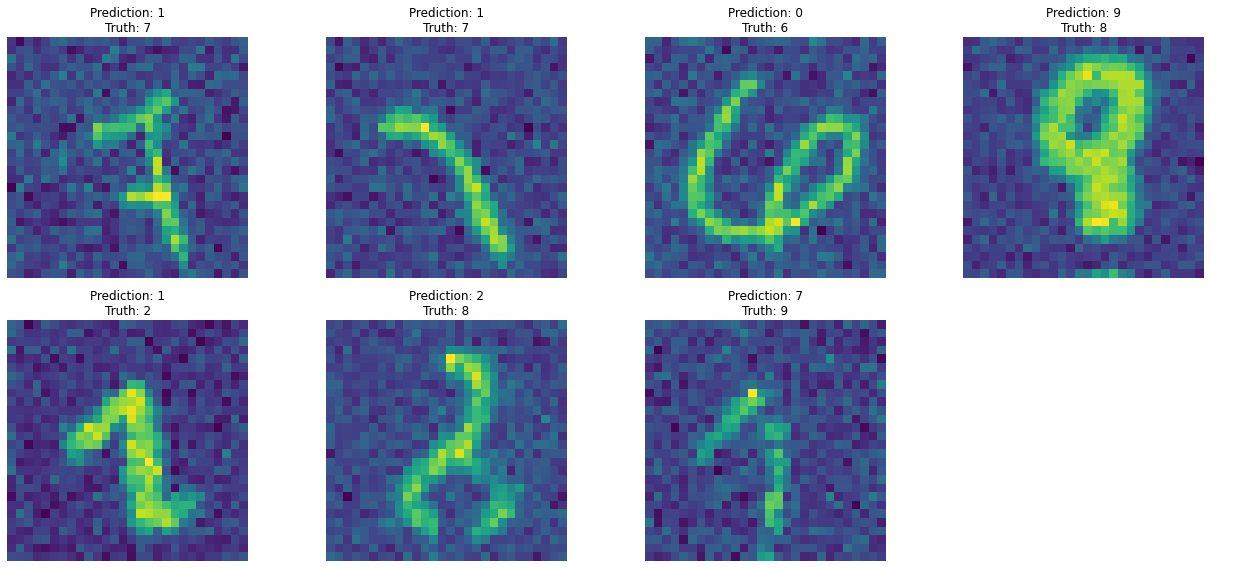

In [51]:
#plot images

def pred_val(i):
	return np.where(i == max(i))[0][0]

test_ds = prepare(val_dataset, augment=True, prefetch=False, cache=False)

with tf.device('/gpu:0'):
	if(PRUNE):
		predictions = model_fast.predict(test_ds)
	else:
		predictions = model.predict(test_ds)

predictions_format = []
for pred in predictions:
	predictions_format.append(pred_val(pred))
predictions = predictions_format

test_images = []
test_labels = []
test_ds = augment_images(test_ds.unbatch())
for idx, elem in enumerate(test_ds):
	test_images.append(elem[0].numpy()) # images
	test_labels.append(elem[1].numpy()) # labels

indices = [i for i, v in enumerate(predictions) if v != test_labels[i]]
wrong_predictions = [[test_images[i], predictions[i], test_labels[i]] for i in indices ]
wrong_predictions_count = len(wrong_predictions)

if(wrong_predictions_count > 0):
	print("{} wrong predictions found out of {} correct".format(wrong_predictions_count, len(predictions)))
	columns = 4
	fig, axes = plt.subplots(wrong_predictions_count//columns+1, min(wrong_predictions_count, columns), figsize=(18, max((wrong_predictions_count//columns)*2*columns,columns)))
	if(wrong_predictions_count <= 1):
		count = [axes]
	else:
		count = axes.flat
	for idx, elem in enumerate(count):
		if(wrong_predictions_count <= 1):
			ax = axes
		else:
			ax = axes.flat[idx]

		if(len(wrong_predictions) <= idx):
			ax.axis("off")
			continue
		image = wrong_predictions[idx][0]
		label = str(wrong_predictions[idx][2])
		prediction = str(wrong_predictions[idx][1])

		ax.axis("off")
		ax.imshow(image)
		ax.set_title("Prediction: "+prediction+"\nTruth: "+label)
	plt.tight_layout()
	plt.show()
else:
	print("No wrong predictions!")